In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [18]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [19]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
test_batch_size = 1000
batch_size = 64
epochs = 14
lr = 0.1
gamma = 0.7
seed = 1
no_cuda = False
log_interval = 10
save_model = True
use_cuda = True

In [8]:
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [10]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

In [11]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [20]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.275600
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.723830
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.951549
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.134733
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.912685
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.713141
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.743853
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.368777
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.524929
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.624067
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.363500
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.386429
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.382891
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.439181
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.537570
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.311357
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.533116
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.451347
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.630364
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.611748
Train Epoch: 1 [12800/60000 (

Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.141338
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.167105
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.236326
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.200068
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.134443
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.273011
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.081437
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.114573
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.033596
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.049387
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.057621
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.117352
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.034758
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.087466
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.190559
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.098786
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.041508
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.168789
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.107736
Train Epoch: 2 [56960/60000 (95%)]	Loss: 0.090856


Train Epoch: 4 [30080/60000 (50%)]	Loss: 0.112313
Train Epoch: 4 [30720/60000 (51%)]	Loss: 0.013066
Train Epoch: 4 [31360/60000 (52%)]	Loss: 0.082646
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.117425
Train Epoch: 4 [32640/60000 (54%)]	Loss: 0.037317
Train Epoch: 4 [33280/60000 (55%)]	Loss: 0.036625
Train Epoch: 4 [33920/60000 (57%)]	Loss: 0.098760
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.065608
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.021014
Train Epoch: 4 [35840/60000 (60%)]	Loss: 0.146863
Train Epoch: 4 [36480/60000 (61%)]	Loss: 0.058070
Train Epoch: 4 [37120/60000 (62%)]	Loss: 0.134500
Train Epoch: 4 [37760/60000 (63%)]	Loss: 0.086529
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.162349
Train Epoch: 4 [39040/60000 (65%)]	Loss: 0.022879
Train Epoch: 4 [39680/60000 (66%)]	Loss: 0.012033
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.046412
Train Epoch: 4 [40960/60000 (68%)]	Loss: 0.176385
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.142106
Train Epoch: 4 [42240/60000 (70%)]	Loss: 0.171189


Train Epoch: 6 [14720/60000 (25%)]	Loss: 0.100593
Train Epoch: 6 [15360/60000 (26%)]	Loss: 0.033967
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.276400
Train Epoch: 6 [16640/60000 (28%)]	Loss: 0.020342
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.093452
Train Epoch: 6 [17920/60000 (30%)]	Loss: 0.067461
Train Epoch: 6 [18560/60000 (31%)]	Loss: 0.019498
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.073370
Train Epoch: 6 [19840/60000 (33%)]	Loss: 0.054342
Train Epoch: 6 [20480/60000 (34%)]	Loss: 0.019609
Train Epoch: 6 [21120/60000 (35%)]	Loss: 0.098260
Train Epoch: 6 [21760/60000 (36%)]	Loss: 0.067237
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.084675
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.178335
Train Epoch: 6 [23680/60000 (39%)]	Loss: 0.093910
Train Epoch: 6 [24320/60000 (41%)]	Loss: 0.096974
Train Epoch: 6 [24960/60000 (42%)]	Loss: 0.127462
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.144273
Train Epoch: 6 [26240/60000 (44%)]	Loss: 0.049321
Train Epoch: 6 [26880/60000 (45%)]	Loss: 0.073413



Test set: Average loss: 0.0388, Accuracy: 9867/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.038924
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.020291
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.051052
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.054107
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.016668
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.020540
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.172390
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.203284
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.060112
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.073123
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.038578
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.011136
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.019414
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.089951
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.055928
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.020246
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.149444
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.115972
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.063732
Train Epoch: 8 [12

Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.143137
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.025355
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.182920
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.010409
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.030368
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.050461
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.019557
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.022115
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.011682
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.053879
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.029867
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.129888
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.014768
Train Epoch: 9 [53120/60000 (88%)]	Loss: 0.063692
Train Epoch: 9 [53760/60000 (90%)]	Loss: 0.025935
Train Epoch: 9 [54400/60000 (91%)]	Loss: 0.019980
Train Epoch: 9 [55040/60000 (92%)]	Loss: 0.004855
Train Epoch: 9 [55680/60000 (93%)]	Loss: 0.189602
Train Epoch: 9 [56320/60000 (94%)]	Loss: 0.136545
Train Epoch: 9 [56960/60000 (95%)]	Loss: 0.006562


Train Epoch: 11 [28160/60000 (47%)]	Loss: 0.047109
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.043337
Train Epoch: 11 [29440/60000 (49%)]	Loss: 0.060211
Train Epoch: 11 [30080/60000 (50%)]	Loss: 0.045466
Train Epoch: 11 [30720/60000 (51%)]	Loss: 0.013603
Train Epoch: 11 [31360/60000 (52%)]	Loss: 0.134532
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.034175
Train Epoch: 11 [32640/60000 (54%)]	Loss: 0.036886
Train Epoch: 11 [33280/60000 (55%)]	Loss: 0.024996
Train Epoch: 11 [33920/60000 (57%)]	Loss: 0.045725
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.024371
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.109809
Train Epoch: 11 [35840/60000 (60%)]	Loss: 0.098940
Train Epoch: 11 [36480/60000 (61%)]	Loss: 0.012211
Train Epoch: 11 [37120/60000 (62%)]	Loss: 0.008973
Train Epoch: 11 [37760/60000 (63%)]	Loss: 0.079625
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.065441
Train Epoch: 11 [39040/60000 (65%)]	Loss: 0.049959
Train Epoch: 11 [39680/60000 (66%)]	Loss: 0.024472
Train Epoch: 11 [40320/60000 (6

Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.048758
Train Epoch: 13 [12160/60000 (20%)]	Loss: 0.010663
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.169865
Train Epoch: 13 [13440/60000 (22%)]	Loss: 0.053502
Train Epoch: 13 [14080/60000 (23%)]	Loss: 0.113073
Train Epoch: 13 [14720/60000 (25%)]	Loss: 0.027474
Train Epoch: 13 [15360/60000 (26%)]	Loss: 0.021078
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.110279
Train Epoch: 13 [16640/60000 (28%)]	Loss: 0.015194
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.041311
Train Epoch: 13 [17920/60000 (30%)]	Loss: 0.013303
Train Epoch: 13 [18560/60000 (31%)]	Loss: 0.031624
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.063222
Train Epoch: 13 [19840/60000 (33%)]	Loss: 0.047935
Train Epoch: 13 [20480/60000 (34%)]	Loss: 0.035766
Train Epoch: 13 [21120/60000 (35%)]	Loss: 0.262993
Train Epoch: 13 [21760/60000 (36%)]	Loss: 0.087505
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.075481
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.154242
Train Epoch: 13 [23680/60000 (3

Train Epoch: 14 [55680/60000 (93%)]	Loss: 0.027297
Train Epoch: 14 [56320/60000 (94%)]	Loss: 0.017508
Train Epoch: 14 [56960/60000 (95%)]	Loss: 0.038715
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.080551
Train Epoch: 14 [58240/60000 (97%)]	Loss: 0.070490
Train Epoch: 14 [58880/60000 (98%)]	Loss: 0.073828
Train Epoch: 14 [59520/60000 (99%)]	Loss: 0.112276

Test set: Average loss: 0.0376, Accuracy: 9873/10000 (99%)



In [22]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [23]:
print(example_targets.shape)
print(example_data.shape)

torch.Size([1000])
torch.Size([1000, 1, 28, 28])


In [24]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [25]:
x = example_data[0,:,:,:].unsqueeze_(0).requires_grad_(True)
print(x.shape)

y = example_targets[0]

torch.Size([1, 1, 28, 28])


In [30]:
y_hat = model(x.cuda())
y_hat.shape

torch.Size([1, 10])

In [32]:
y_hat.argmax()

tensor(9, device='cuda:0')

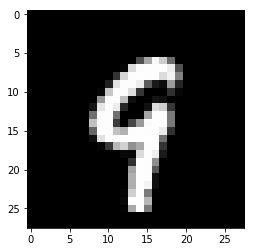

In [34]:
import matplotlib.pyplot as plt
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')

In [36]:
# df/dx
ddx, = torch.autograd.grad(model(x.cuda()).mean(), x, create_graph=True)

In [38]:
ddx.shape

torch.Size([1, 1, 28, 28])

In [39]:
ddx.mean().backward()
# x.grad = d^2 f(x)/dx^2

In [43]:
#d^2 f(x)/dx^2
x.grad

tensor([[[[-1.6618e-08,  1.5430e-08, -1.1071e-08,  8.3315e-09, -3.9939e-08,
           -2.2935e-08, -4.7874e-08, -8.5484e-09, -2.5105e-08, -1.2877e-08,
           -1.4104e-08, -1.7205e-08, -3.7460e-08, -2.7109e-08, -3.7510e-08,
           -2.5198e-08, -2.1239e-08, -1.3336e-08, -1.8152e-08, -2.0602e-09,
           -1.2820e-08,  8.8868e-09, -4.2368e-08,  6.4144e-09, -3.4444e-09,
           -1.7543e-08, -2.2537e-08,  0.0000e+00],
          [-7.6794e-10, -4.0324e-08, -8.7975e-08, -1.1749e-07, -1.3423e-07,
           -1.2425e-07, -1.3394e-07, -1.1107e-07, -1.1151e-07, -1.1751e-07,
           -1.1061e-07, -1.1829e-07, -1.2927e-07, -1.0698e-07, -8.9417e-08,
           -2.5580e-08, -2.1562e-08, -2.5660e-08, -2.7209e-08, -3.9931e-08,
           -5.8219e-08, -6.4564e-08, -8.3743e-08, -9.9357e-08, -1.3879e-07,
           -8.0310e-08, -4.3735e-08,  0.0000e+00],
          [-3.2500e-08, -7.2102e-08, -2.1601e-07, -2.4887e-07, -2.4221e-07,
           -2.1854e-07, -2.8868e-07, -1.7893e-07, -2.3141e-07,

In [42]:
### taylor series
str("P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...")

'P(x) = f(a) + (df(a)/dx)(x-a)/1! + (d^2f(a)/dx^2)(x-a)^2/2! + ...'

In [46]:
y_hat.shape

torch.Size([1, 10])

In [44]:
# f'(x)
ddx.shape

torch.Size([1, 1, 28, 28])

In [45]:
# f''(x)
x.grad.shape

torch.Size([1, 1, 28, 28])

In [52]:
terms = ddx*x + x.grad*(x.pow(2))

In [54]:
terms.shape

torch.Size([1, 1, 28, 28])